# Example of the Workflow

This is an example of main.py in the ionic_liquids folder. This notebook is based upon the functions in utils.py and methods/methods.py. I have written this code in such a way that the function will come first and the calling of the function comes right after it. I will first have to import the libraries that are necessary to run this program, including train_test_split that allows for splitting datasets into training sets and test sets necessary to run machine learning. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as Calculator
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from numpy import linalg as LA

For this example, I will utilize the following filename, machine learning model, and  directory name to save the model. 

In [2]:
FILENAME = 'compounddata.xlsx'
MODEL = 'mlp_regressor'
DIRNAME = 'my_test'

The following step prepares the data to be read in the machine_learning methods. First, we need to get the data into a readable form and parse, if necessary. In our case, we need to parse the values and errors in the last column of the FILENAME.

In [3]:
def read_data(filename):
    """
    Reads data in from given file to Pandas DataFrame

    Inputs
    -------
    filename : string of path to file

    Returns
    ------
    df : Pandas DataFrame

    """
    cols = filename.split('.')
    name = cols[0]
    filetype = cols[1]
    if (filetype == 'csv'):
        df = pd.read_csv(filename)
    elif (filetype in ['xls', 'xlsx']):
        df = pd.read_excel(filename)
    else:
        raise ValueError('Filetype not supported')

    # clean the data if necessary
    df['EC_value'], df['EC_error'] = zip(*df['ELE_COD'].map(lambda x: x.split('±')))
    y_error = np.copy(df['EC_error'])
    df = df.drop('EC_error', 1)
    df = df.drop('ELE_COD', 1)

    return df, y_error

df, y_error = read_data(FILENAME)


We will send our data to the molecular descriptor function that will create the molecular descriptors for us, resulting in the X matrix and y vector. Specifically, the X matrix will hold all of our inputs for the machine learning whereas y vector will be the actual electronic conductivity values. 

In [4]:
def molecular_descriptors(data):
    """
    Use RDKit to prepare the molecular descriptor

    Inputs
    ------
    data: dataframe, cleaned csv data

    Returns
    ------
    prenorm_X: dataframe, normalized input features
    Y: dataframe, experimental electrical conductivity

    """
    
    n = data.shape[0]
    # Choose which molecular descriptor we want
    list_of_descriptors = ['NumHeteroatoms', 'ExactMolWt',
        'NOCount', 'NumHDonors',
        'RingCount', 'NumAromaticRings', 
        'NumSaturatedRings', 'NumAliphaticRings']
    # Get the molecular descriptors and their dimension
    calc = Calculator(list_of_descriptors)
    D = len(list_of_descriptors)
    d = len(list_of_descriptors)*2 + 4
    #Setting up the X and Y matrices
    X = np.zeros((n, d))
    Y = data['EC_value']
    X[:, -3] = data['T']
    X[:, -2] = data['P']
    X[:, -1] = data['MOLFRC_A']
    for i in range(n):
        A = Chem.MolFromSmiles(data['A'][i])
        B = Chem.MolFromSmiles(data['B'][i])
        X[i][:D]    = calc.CalcDescriptors(A)
        X[i][D:2*D] = calc.CalcDescriptors(B)

    prenorm_X = pd.DataFrame(X,columns=['NUM', 'NumHeteroatoms_A', 
        'MolWt_A', 'NOCount_A','NumHDonors_A', 
        'RingCount_A', 'NumAromaticRings_A', 
        'NumSaturatedRings_A',
        'NumAliphaticRings_A', 
        'NumHeteroatoms_B', 'MolWt_B', 
        'NOCount_B', 'NumHDonors_B',
        'RingCount_B', 'NumAromaticRings_B', 
        'NumSaturatedRings_B', 
        'NumAliphaticRings_B',
        'T', 'P', 'MOLFRC_A'])

    prenorm_X = prenorm_X.drop('NumAliphaticRings_A', 1)
    prenorm_X = prenorm_X.drop('NumAliphaticRings_B', 1)

    return prenorm_X,Y

X, y = molecular_descriptors(df)


We can prepare our testing and training data set for the machine learning calling using train_test_split, a function called from sklearn module of python. 

In [5]:
Y = np.empty((y.shape[0],2))
Y[:,0] = y.ravel()
Y[:,1] = y_error.ravel()

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.10)

y_train = Y_train[:,0]
y_test = Y_test[:,0]
e_train = Y_train[:,1]
e_test = Y_test[:,1]


Followingly, the program will normalize the testing data using the training data set. This will also provide us with the mean value and standard deviation of X. 

In [6]:
def normalization(data,means=None,stdevs=None):
    """
    Normalizes the data using the means and standard
    deviations given, calculating them otherwise.
    Returns the means and standard deviations of columns.

    Inputs
    ------
    data : Pandas DataFrame
    means : optional numpy argument of column means
    stdevs : optional numpy argument of column st. devs

    Returns
    ------
    normed : the normalized DataFrame
    means : the numpy row vector of column means
    stdevs : the numpy row vector of column st. devs

    """
    cols = data.columns
    data = data.values

    if (means is None) or (stdevs is None):
        means = np.mean(data, axis=0)
        stdevs = np.std(data, axis=0, ddof=1)
    else:
        means = np.array(means)
        stdevs = np.array(stdevs)

    # handle special case of one row
    if (len(data.shape) == 1) or (data.shape[0] == 1):
        for i in range(len(data)):
            data[i] = (data[i] - means[i]) / stdevs[i]
    else: 
        for i in range(data.shape[1]):
            data[:,i] = (data[:,i] - means[i]*np.ones(data.shape[0])) / stdevs[i]

    normed = pd.DataFrame(data, columns=cols)

    return normed, means, stdevs

X_train, X_mean, X_std = normalization(X_train)
X_test, trash, trash = normalization(X_test,means=X_mean,stdevs=X_std)

We coded three models into our program:  MLP_regressor, LASSO, and SVR.  Each of these models are  well documented in  sklearn, a library in  python.  *In the actual program, you can use all three models, but for the purpose of this example, we chose mlp_regressor.* The ValueError will only raise if you do not use one of the three models. A good example is if you were to change the MODEL used to 'MLP_classifier'.  

In [7]:
def do_svr(X,Y):
    Y.ravel()
    """
    Call the Support Vector Regressor, 
    Fit the weight on the training set
    
    Input
    ------
    X: dataframe, n*m, n is number of data points, 
        m is number of features
    y: experimental electrical conductivity
    
    Returns
    ------
    svr: objective, the regressor objective 
    """
    
    svr = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001,
        C=1.0, epsilon=0.01, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
    grid_search = GridSearchCV(svr, cv=5, param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)})
    grid_search.fit(X,Y)
    
    svr.alpha_ = grid_search.best_params_['alpha']
    svr.fit(X,Y)
    return svr

def do_MLP_regressor(X,Y):
    Y.ravel()
    """
    Call the MLP Regressor, 
    Fit the weight on the training set
    
    Input
    ------
    X: dataframe, n*m, n is number of data points, 
        m is number of features
    y: experimental electrical conductivity
    
    Returns
    ------
    mlp_regr : the MLP object with the best parameters
    """    
    alphas = np.array([0.1,0.01,0.001,0.0001])
    mlp_regr = MLPRegressor(hidden_layer_sizes=(100,), activation='tanh',
        solver='sgd', alpha=0.0001, max_iter=5000, random_state=None,learning_rate_init=0.01)
    grid_search = GridSearchCV(mlp_regr, param_grid=dict(alpha=alphas))
    grid_search.fit(X,Y)
    
    #print(grid_search.best_params_)
    mlp_regr.alpha_ = grid_search.best_params_['alpha']
    mlp_regr.fit(X,Y)

    return mlp_regr

def do_lasso(X,Y): 
    Y.ravel()
    """
    Runs a lasso grid search on the input data
    
    Inputs
    ------
    X: dataframe, n*m, n is number of data points, 
        m is number of features
    y: experimental electrical conductivity
    
    Returns
    ------
    lasso : sklearn object with the model information 
    """
    
    alphas = np.array([0.1,0.01,0.001,0.0001])
    lasso = Lasso(alpha=0.001, fit_intercept=True, normalize=False, precompute=False,
        copy_X=True, max_iter=10000, tol=0.001, positive=False, random_state=None, selection='cyclic')
    gs = GridSearchCV(lasso, param_grid=dict(alpha=alphas))
    gs.fit(X,Y)
    
    lasso.alpha_ = gs.best_params_['alpha']

    lasso.fit(X,Y)
        
    return lasso


The code below are calling to the functions above and is the machine learning portion of the package. 

In [8]:
if (MODEL.lower() == 'mlp_regressor'):
    obj = do_MLP_regressor(X_train, y_train.ravel())
elif (MODEL.lower() == 'lasso'):
    obj = do_lasso(X_train, y_train.ravel())
elif (MODEL.lower() == 'svr'):
    obj = do_svr(X_train, y_train.ravel())
else:
    raise ValueError("Model not supported")

Lastly, the experimental values will be scatter plotted against the predicted values. We will use the parity_plot to do so. plt.show()  function will just allow the plot to show up. 

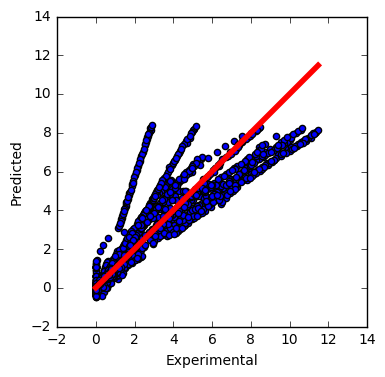

In [9]:
FIG_SIZE = (4,4)

def parity_plot(Y_act, Y_pred):
    """
    Creates a parity plot

    Input
    -----
    y_pred : predicted values from the model (Lasso, SVR, or MLP)
    y_act : 'true' (actual) values

    Output
    ------
    fig : matplotlib figure

    """

    fig = plt.figure(figsize=FIG_SIZE)
    plt.scatter(list(Y_act), list(Y_pred))
    plt.plot([Y_act.min(), Y_act.max()], [Y_act.min(), Y_act.max()],
             lw=4, color='r')
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')

    return fig

my_plot = parity_plot(y_train, obj.predict(X_train))
plt.show(my_plot)

The error_values function calculates and provides the prediction values to create the plot of prediction values versus the experimental values. 

float64 float64 float64 float64
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1) float64
(100, 18) (100, 1)
(100, 1)
(100, 100) float64 (2270, 18) float64 (100, 1)

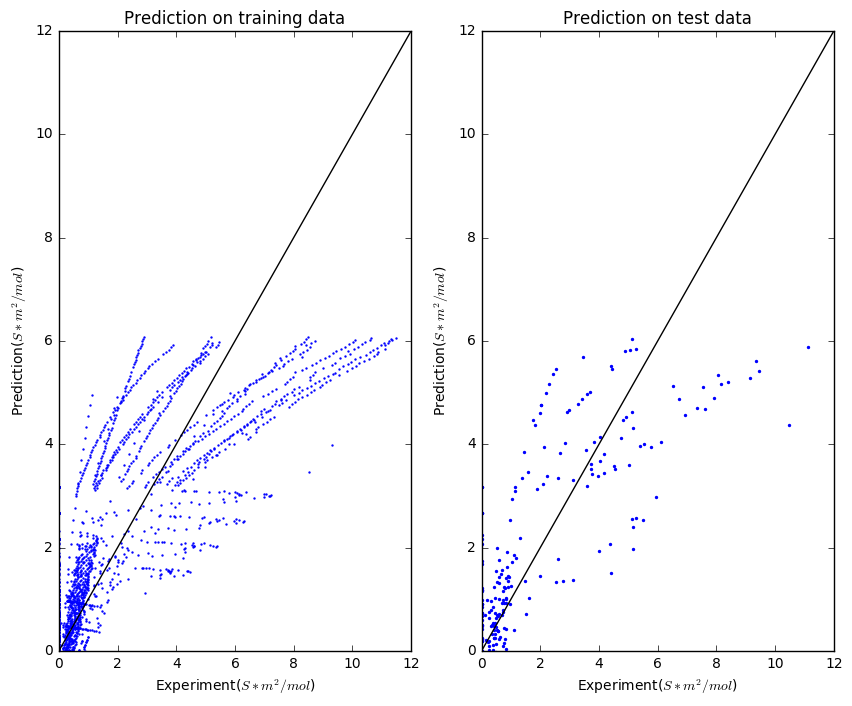

In [22]:
def error_values(X_train,X_test,Y_train,Y_test):
    """
    Creates the two predicted values

    Input
    -----
    X_train : numpy array, the 10% of the training set data values
    X_test : numpy array, the molecular descriptors for the testing set data values 

    Y_train: numpy array, the 10% of the training set of electronic conductivity values
    Y_test: numpy array, 'true' (actual) electronic conductivity values
    
    Output
    ------
    yh : the prediction output for training data set
    yh2 : the prediction output for the testing data set 
    """
    #setting up parameters and variables for plotting 
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    d = X_train.shape[1]
    hdnode = 100
    w1 = np.random.normal(0,0.001,d*hdnode).reshape((d,hdnode))
    d1 = np.zeros((d,hdnode))
    w2 = np.random.normal(0,0.001,hdnode).reshape((hdnode,1))
    d2 = np.zeros(hdnode)
    h  = np.zeros(hdnode)
    mb = 100 #minibatch size
    m = int(n_train/mb)
    batch = np.arange(m) 
    lr = 0.00020
    EP = 20000 #needed for initializing 
    ep = 0
    y = np.zeros((mb,1))
    yh = np.zeros((n_train,1))
    yh2 = np.zeros((n_test,1))
    L_train= np.zeros(EP+1)
    L_test = np.zeros(EP+1)
    Y_train = Y_train.reshape(len(Y_train),1)
        
    #activation function for the hidden layer is tanh
    def g(A):
        return (np.tanh(A))

    def gd(A):
        return (1-np.square(np.tanh(A)))
        
    #setting up how long the epoch will run
    EP = 20
    ep = 0
    while ep < EP:
        ep += 1
        yh = g(X_train.dot(w1)).dot(w2)
        yh2 = g(X_test.dot(w1)).dot(w2)
        print(yh.dtype,yh2.dtype,Y_train.dtype,Y_test.dtype)
        L_train[ep] = LA.norm(yh-Y_train.reshape(len(Y_train),1))/n_train
        L_test[ep]  = LA.norm(yh2-Y_test.reshape(len(Y_test),1))/n_test
        
        np.random.shuffle(batch)
        for i in range(m):
            st = batch[i]*mb
            ed = (batch[i]+1)*mb
            h  = g(X_train[st:ed].dot(w1))
            y = h.dot(w2)
            d2 = h.T.dot(Y_train[st:ed]-y)
            print (d2.shape)
            print(h.shape, h.dtype, X_train.shape, X_train.dtype, y.shape, y.dtype)
            print((X_train[st:ed]).shape,(Y_train[st:ed]-y).shape)
            d1 = X_train[st:ed].T.dot(np.multiply((Y_train[st:ed]-y).dot(w2.T),gd(X_train[st:ed].dot(w1))))
            w2 += lr*d2
            w1 += lr*d1
    return yh, yh2

yh, yh2 = error_values(np.copy(X_train),np.copy(X_test),np.copy(y_train),np.copy(y_test))

#Creates a plot for the training data set predicted and experimental values 
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.scatter(y_train,yh,s=0.5,color='blue')
plt.title('Prediction on training data')
plt.plot(np.linspace(0,12,1000),np.linspace(0,12,1000),color='black')
plt.xlim((0,12))
plt.ylim((0,12))
plt.xlabel("Experiment($S*m^2/mol$)")
plt.ylabel("Prediction($S*m^2/mol$)")

#Creates a plot for the testing data set predicted and experimental values 
plt.subplot(1,2,2)
plt.scatter(y_test,yh2,s=2,color='blue')
plt.title('Prediction on test data')
plt.xlim((0,12))
plt.ylim((0,12))
plt.xlabel("Experiment($S*m^2/mol$)")
plt.ylabel("Prediction($S*m^2/mol$)")
plt.plot(np.linspace(0,12,1000),np.linspace(0,12,1000),color='black')
plt.show()


The following input will provides a plot that will compare the experimental and predicted data to the experimental error provided by the ILThermo database. The x and y axis limits are based upon the percent that you pick in the test_training_split function. 

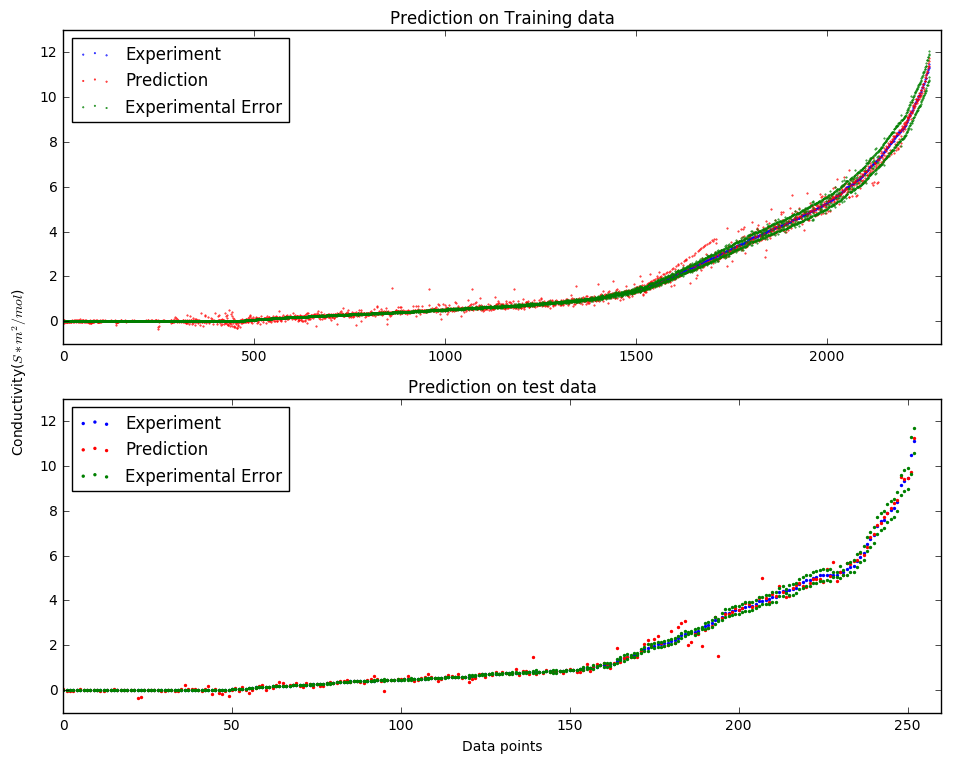

In [13]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#Set up the training data set plot
result = pd.DataFrame(columns=['Experiment','Prediction','error'])
result.Experiment = y_train
result.Prediction = yh
result.error = e_train
result = result.sort_values(['Experiment','Prediction'],ascending=[1,1])

size=0.2
ax1.set_xlim((0,2300))
ax1.set_ylim((-1,13))
ax1.scatter(np.arange(X_train.shape[0]),result.Experiment,color="blue",s=size,label='Experiment')
ax1.scatter(np.arange(X_train.shape[0]),result.Prediction,color="red",s=size,label='Prediction')
ax1.scatter(np.arange(X_train.shape[0]),result.Experiment+result.error,color="green",s=size,label='Experimental Error')
ax1.scatter(np.arange(X_train.shape[0]),result.Experiment-result.error,color="green",s=size)
ax1.set_title('Prediction on Training data')
ax1.legend(loc='upper left')

#setting up the test data set plot 
result = pd.DataFrame(columns=['Experiment','Prediction','error'])
result.Experiment = y_test
result.Prediction = yh2
result.error = e_test
result = result.sort_values(['Experiment','Prediction'],ascending=[1,1])

size=2
ax2.set_xlim((0,260))
ax2.set_ylim((-1,13))
ax2.scatter(np.arange(X_test.shape[0]),result.Experiment,color="blue",s=size,label='Experiment')
ax2.scatter(np.arange(X_test.shape[0]),result.Prediction,color="red",s=size,label='Prediction')
ax2.scatter(np.arange(X_test.shape[0]),result.Experiment+result.error,color="green",s=size,label='Experimental Error')
ax2.scatter(np.arange(X_test.shape[0]),result.Experiment-result.error,color="green",s=size)
ax2.set_title('Prediction on test data')
ax2.legend(loc='upper left')

ax.set_xlabel('Data points')
ax.set_ylabel('Conductivity($S*m^2/mol$)')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
fig.tight_layout()
plt.show()

 I hope you enjoy our package and use it to fit your needs!